   user_id    name     location  total_influence        country   event_type  \
0   663432  bdraco  Houston, TX      1776.967163  United States  CreateEvent   
1   663432  bdraco  Houston, TX      1776.967163  United States  CreateEvent   
2   663432  bdraco  Houston, TX      1776.967163  United States  CreateEvent   
3   663432  bdraco  Houston, TX      1776.967163  United States  CreateEvent   
4   663432  bdraco  Houston, TX      1776.967163  United States  CreateEvent   

  event_action                 event_time  
0        added  2024-11-26 20:28:37+08:00  
1        added  2024-11-26 20:42:57+08:00  
2        added  2024-11-27 04:10:46+08:00  
3        added  2024-11-27 17:43:50+08:00  
4        added  2024-11-27 19:56:34+08:00  
user_id                0
name                   0
location               0
total_influence        0
country            88151
event_type             0
event_action           0
event_time             0
dtype: int64


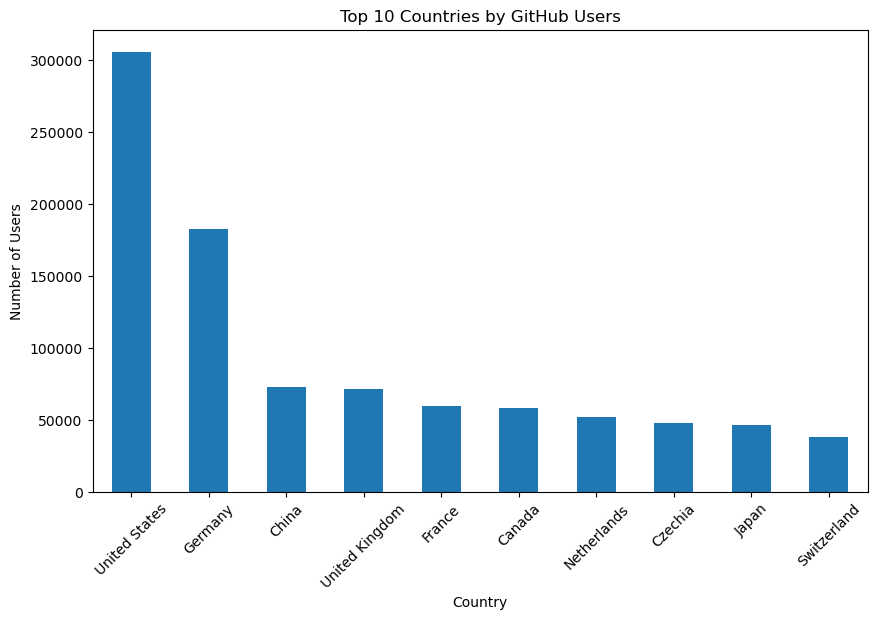

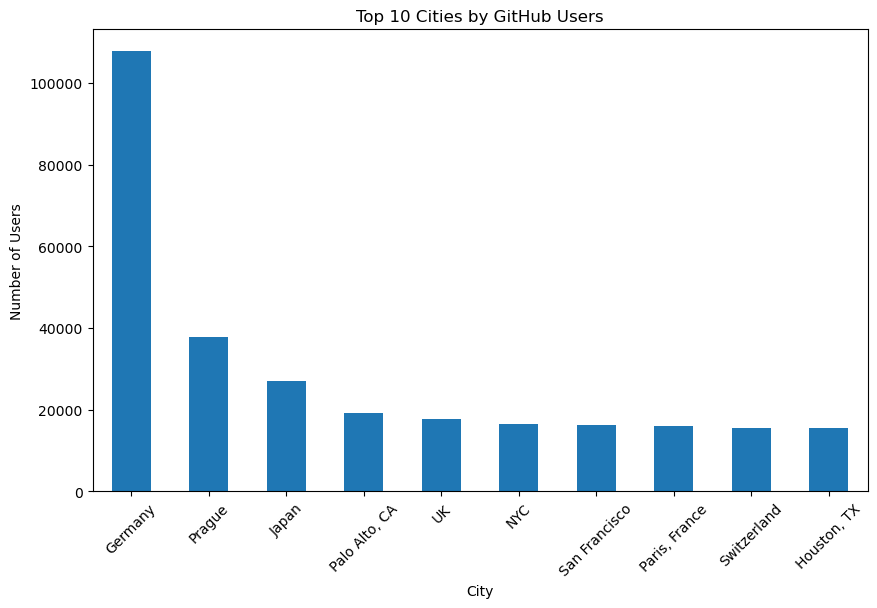

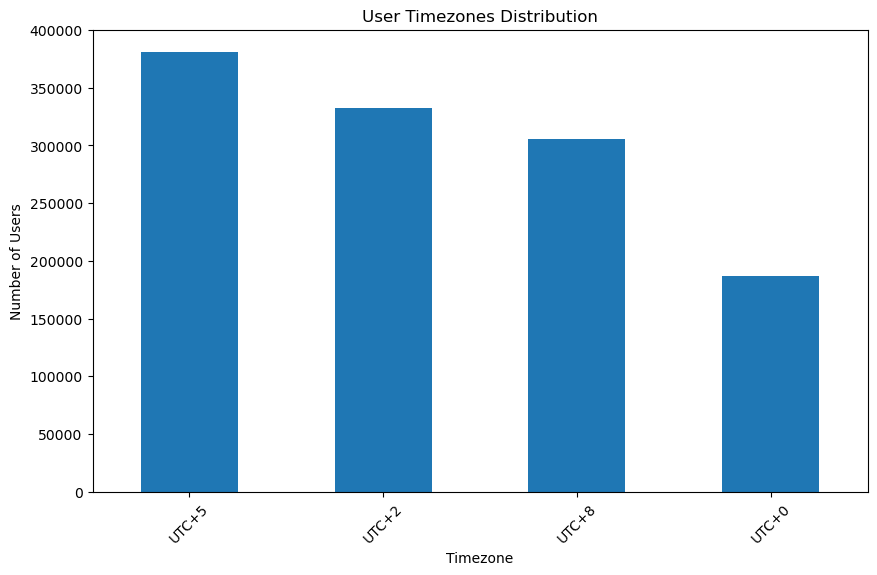

High activity users:
Series([], dtype: int64)
Low activity users:
Series([], dtype: int64)


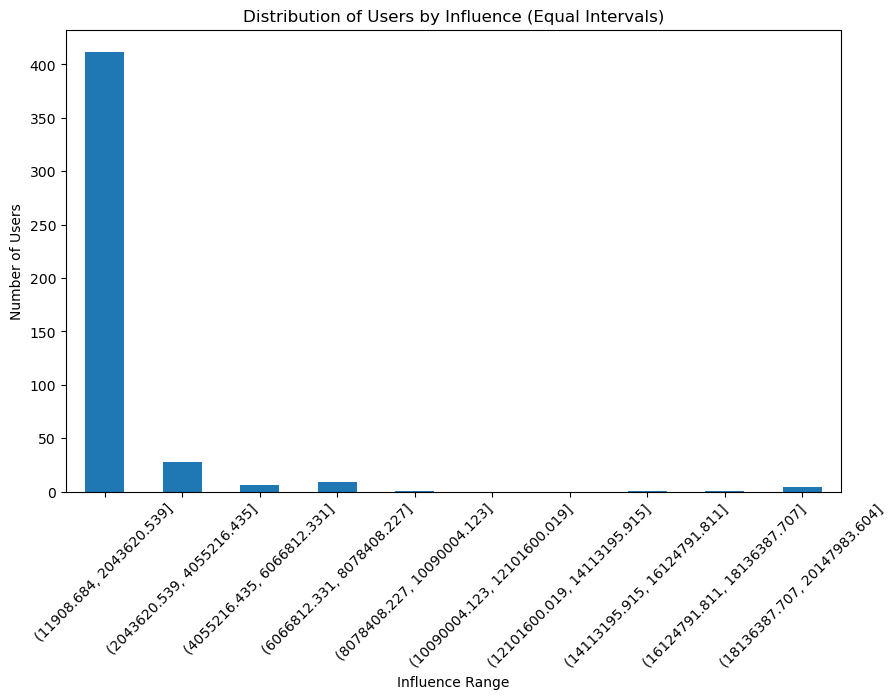

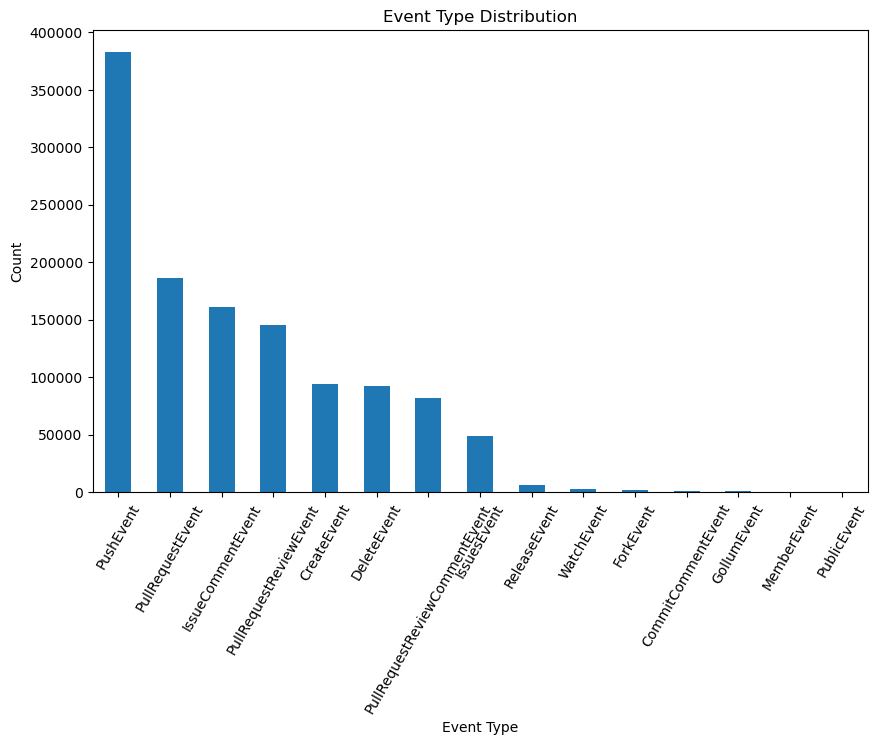

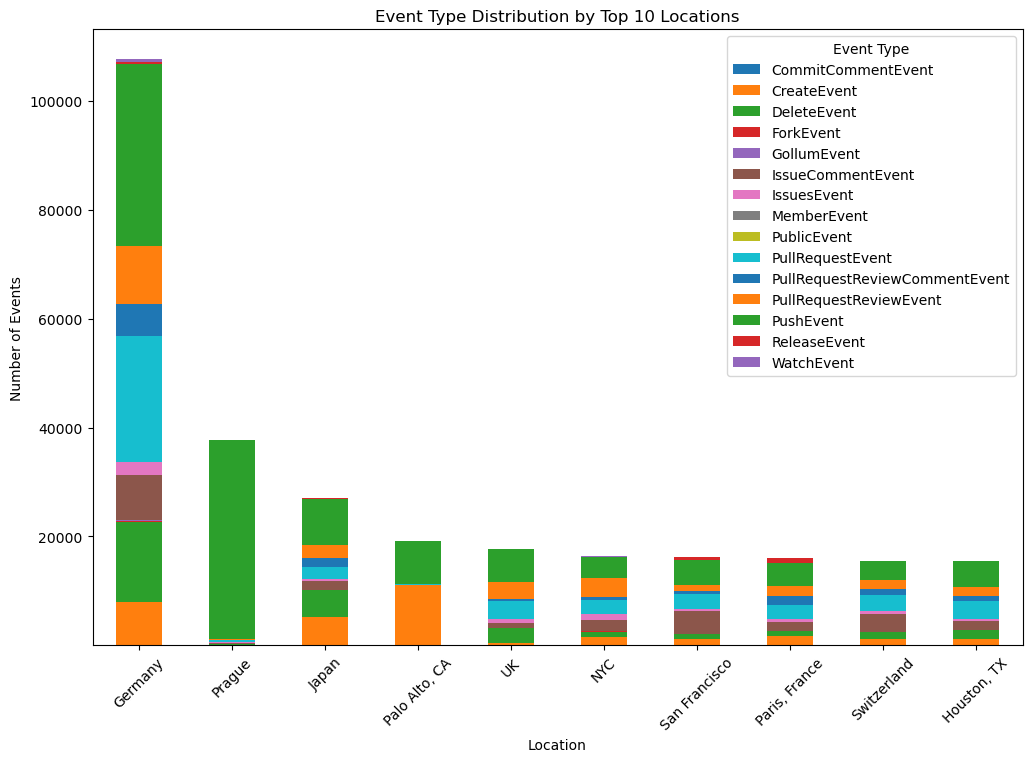

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# 加载数据
data = pd.read_csv('users_combined_info_500.csv')

# 查看数据结构
print(data.head())

# 检查缺失值
print(data.isnull().sum())

# 数据清洗，去除缺失的国家、事件时间等关键列
data_clean = data.dropna(subset=['country', 'event_time', 'total_influence'])

# 转换 event_time 为 datetime 类型
data_clean.loc[:,['event_time']]=pd.to_datetime(data_clean['event_time'])

# 通过用户的活跃时间推断时区（假设按活动时间推算为UTC+0到UTC+8之间的时区）
def get_timezone(event_time):
    hour = event_time.hour
    if hour >= 0 and hour < 6:
        return 'UTC+0'
    elif hour >= 6 and hour < 12:
        return 'UTC+2'
    elif hour >= 12 and hour < 18:
        return 'UTC+5'
    else:
        return 'UTC+8'

# 为每个用户添加时区信息
data_clean.insert(0, 'timezone', data_clean['event_time'].apply(get_timezone), allow_duplicates = False)


# 国家分布
country_distribution = data_clean['country'].value_counts().head(10)

# 可视化
plt.figure(figsize=(10, 6))
country_distribution.plot(kind='bar')
plt.title('Top 10 Countries by GitHub Users')
plt.xlabel('Country')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)
plt.show()

# 城市分布（假设城市信息存储在location列中）
city_distribution = data_clean['location'].value_counts().head(10)

plt.figure(figsize=(10, 6))
city_distribution.plot(kind='bar')
plt.title('Top 10 Cities by GitHub Users')
plt.xlabel('City')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)
plt.show()

# 时区分布
timezone_distribution = data_clean['timezone'].value_counts()

plt.figure(figsize=(10, 6))
timezone_distribution.plot(kind='bar')
plt.title('User Timezones Distribution')
plt.xlabel('Timezone')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)
plt.show()

# 提交频率分析
submit_frequency = data_clean[data_clean['event_action'] == 'push'].groupby('user_id').size()

# 找到高活跃与低活跃用户
high_activity_users = submit_frequency[submit_frequency > submit_frequency.quantile(0.75)]
low_activity_users = submit_frequency[submit_frequency < submit_frequency.quantile(0.25)]

# 输出高活跃和低活跃用户
print(f"High activity users:\n{high_activity_users.head()}")
print(f"Low activity users:\n{low_activity_users.head()}")

# # 用户影响力分析
# influence_distribution = data_clean.groupby('user_id')['total_influence'].sum()

# # 高影响力用户
# high_influence_users = influence_distribution[influence_distribution > influence_distribution.quantile(0.75)]

# plt.figure(figsize=(10, 6))
# high_influence_users.plot(kind='bar')
# plt.title('High Influence Users by Total Influence')
# plt.xlabel('User ID')
# plt.ylabel('Total Influence')
# plt.show()


# 对用户影响力进行按均等区间分组（区间数为10）
influence_distribution = data_clean.groupby('user_id')['total_influence'].sum()

# 使用cut将影响力划分为10个均等的区间
bins = pd.cut(influence_distribution, bins=10)

# 统计每个区间内的用户数量
group_distribution = bins.value_counts().sort_index()

# 可视化影响力分组
plt.figure(figsize=(10, 6))
group_distribution.plot(kind='bar')
plt.title('Distribution of Users by Influence (Equal Intervals)')
plt.xlabel('Influence Range')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)
plt.show()

# 事件类型分布
event_type_distribution = data_clean['event_type'].value_counts()

plt.figure(figsize=(10, 6))
event_type_distribution.plot(kind='bar')
plt.title('Event Type Distribution')
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.xticks(rotation=60)
plt.show()

# 计算每个地理位置和事件类型的分布
location_event_type_distribution = data_clean.groupby(['location', 'event_type']).size().unstack(fill_value=0)

# 计算每个地理位置的总事件数量，并获取前十名
location_total_counts = data_clean['location'].value_counts().head(10)

# 选择前十名地理位置的数据
top_10_locations = location_event_type_distribution.loc[location_total_counts.index]

# 可视化前十名地理位置与事件类型的关系
top_10_locations.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Event Type Distribution by Top 10 Locations')
plt.xlabel('Location')
plt.ylabel('Number of Events')
plt.xticks(rotation=45)
plt.legend(title='Event Type')
plt.show()